In [1]:
#Imports
import csv
import pandas as pd
import numpy as np
from pathlib import Path
from numpy import loadtxt
import xgboost as xgb
import graphviz
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# CSV files:
file_path = Path("Resources/epa-sea-level.csv")

# Create DataFrames
XGBoost_df= pd.read_csv(file_path)#,index_col='Year')
XGBoost_df.head()

,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound
0,1880,0.000000,-0.952756,0.952756
1,1881,0.220472,-0.732283,1.173228
2,1882,-0.440945,-1.346457,0.464567
3,1883,-0.232283,-1.129921,0.665354
4,1884,0.590551,-0.283465,1.464567


In [3]:
#Getting Summary Statistics
XGBoost_df.describe

<bound method NDFrame.describe of      Year  CSIRO Adjusted Sea Level  Lower Error Bound  Upper Error Bound
0    1880                  0.000000          -0.952756           0.952756
1    1881                  0.220472          -0.732283           1.173228
2    1882                 -0.440945          -1.346457           0.464567
3    1883                 -0.232283          -1.129921           0.665354
4    1884                  0.590551          -0.283465           1.464567
5    1885                  0.531496          -0.330709           1.393701
6    1886                  0.437008          -0.381890           1.255906
7    1887                  0.216535          -0.602362           1.035433
8    1888                  0.299213          -0.519685           1.118110
9    1889                  0.362205          -0.456693           1.181102
10   1890                  0.440945          -0.374016           1.255906
11   1891                  0.374016          -0.440945           1.188976
12  

In [4]:
# split data into X and y

X = XGBoost_df.iloc[:,:-1]
y = XGBoost_df.iloc[:,-1]

In [5]:
# Converting the dataset into an optimized data structure called DMatrix
data_dmatrix = xgb.DMatrix(X,y)

In [6]:
# split data into train and test sets
seed = 123
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [7]:
# Instantiate an XGBoost regressor Object
xg_reg = xgb. XGBRegressor()
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                         max_depth = 5, alpha = 10, n_extimators = 10)

## Train the XGBoost Model

In [8]:
# fit model on training data and predict.
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

# Print Model
print(xg_reg)

[14:02:13] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "n_extimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_extimators=10, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda

C:\Users\keith\anaconda3\envs\pyvizenv\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [10]:
# computing the rsme
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('RMSE: %f' %(rmse))

RMSE: 0.137343


In [11]:
#k-fold Cross Validation using XGBoost
params = {'objective':'reg:linear','colsample_bytree': 0.3,'learning_rate':0.1,
         'max_depth':5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                   num_boost_round=50, early_stopping_rounds=10, metrics = 'rmse', as_pandas=True, seed=123)

[14:02:14] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:14] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:14] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [12]:
#Results for train and test RMSE metrics
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3.904050,0.084362,3.900268,0.169583
1,3.575393,0.077065,3.575062,0.152398
2,3.279446,0.070842,3.281611,0.138322
3,3.010903,0.060890,3.009907,0.139041
4,2.768504,0.058042,2.768386,0.137754


In [13]:
# Extracting and printing the final boosting round metric.
print((cv_results['test-rmse-mean']).tail(1))

49    0.475183
Name: test-rmse-mean, dtype: float64


In [14]:
#Visualize Boosting Trees and Feature Importance
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[14:02:14] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


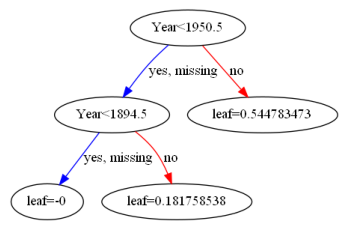

In [15]:
#Plotting the first tree 
#fig,ax=plt.subplots(figsize=(30,30))
xgb.plot_tree(xg_reg, num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

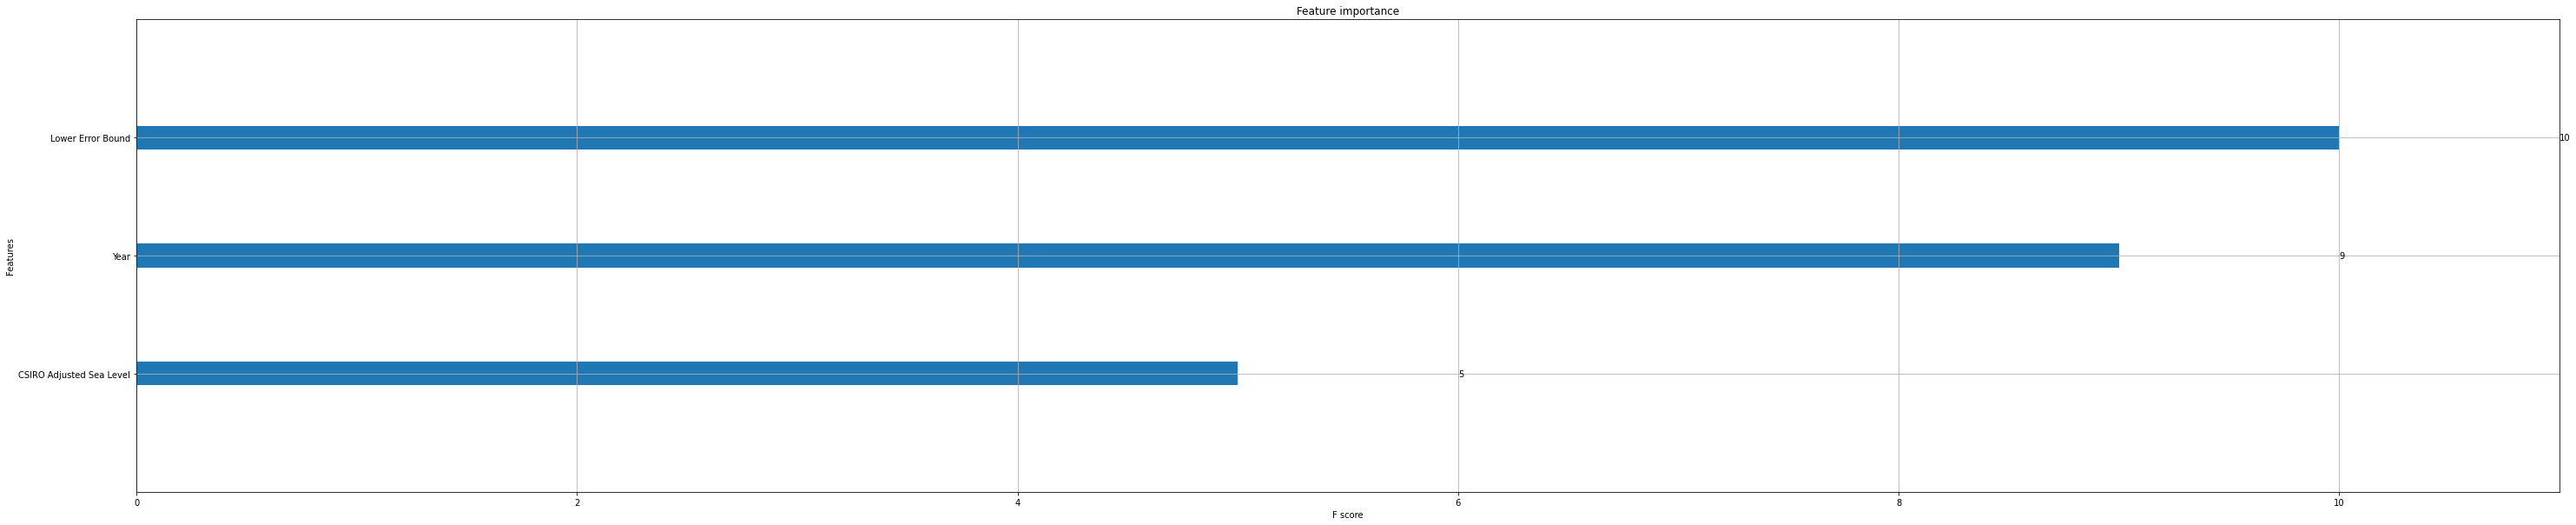

In [16]:
#Visualizing the results as a bar chart

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

Extreme Gradient Boosting(XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm. The Regression predictive modeling used here, involved predicting the increase in sea levels over a period in time (Height of Sea Levels).

Some conclusions were made, with the use of the XGBoost Regression model:
    - XGBoost is an efficient implementation of gradient boosting that can be used for regression predictive modeling.
    - The k-fold cross-validation was used as a technique to evaluate an XGBoost regression model with efficient results.
    - Using the model to make a prediction on new data gave noticeable results, with an RSME Value of : 0.137343
    
The Root Mean Square error(RSME) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RSME is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit, hence it's commonality in climatology, forecasting, and regression analysis to verify experimental results, as was the case here.    